<a href="https://colab.research.google.com/github/minhanh114/datamining/blob/main/fake_job_postings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Thêm thư viện
import random
import missingno
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC

In [ ]:
# Tải tập dữ liệu
data = pd.read_csv('/content/drive/MyDrive/fake_job_postings.csv')

In [ ]:
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
# Kiểm tra số lượng giá trị bị khuyết (NaN) trong từng cột của dataset.
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Kiểm tra dữ liệu trùng
data.duplicated().sum()

0

In [ ]:
# Xóa các thuộc tính không cần thiết trong quá trình phân loại
# Thay thế các giá trị NaN bằng khoảng trắng
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

In [ ]:
data

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


   fraudulent  title
0           0  17014
1           1    866


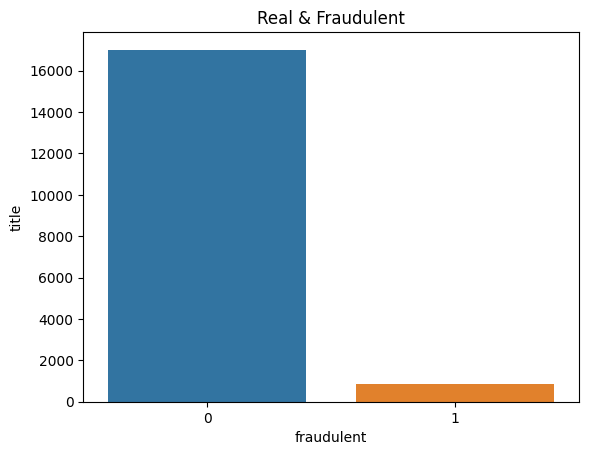

In [ ]:
# Nhóm và đếm
# Áp dụng hàm đếm cho cột 'title', đếm số lượng công việc tương ứng với mỗi nhóm 'fraudulent'
fraud_count = data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title', ascending=False)

# Vẽ biểu đồ cho kết quả
sns.barplot(x='fraudulent', y='title', data=fraud_count).set_title('Real & Fraudulent')
print(fraud_count)



Text(0.5, 0, 'Countries')

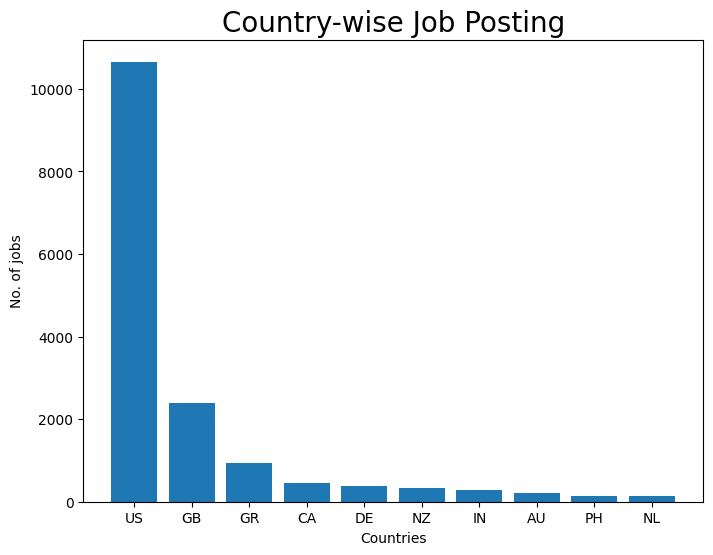

In [ ]:
# Kiểm tra xem giá trị trong cột location có phải là chuỗi hay không
def split_location(location):
    if isinstance(location, str):
        l = location.split(',')
        return l[0]
    else:
        return ''
# Tách đất nước từ cột location và thêm cột mới là 'country'
data['country'] = data.location.apply(split_location)
# Tạo từ điển country với số lượng job postings của 11 quốc gia đứng đầu
country = dict(data.country.value_counts()[:11])
del country[' ']
# Vẽ biểu đồ cột với trục X là tên các quốc gia và trục Y là số lượng job postings của mỗi quốc gia
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)


In [ ]:
data

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


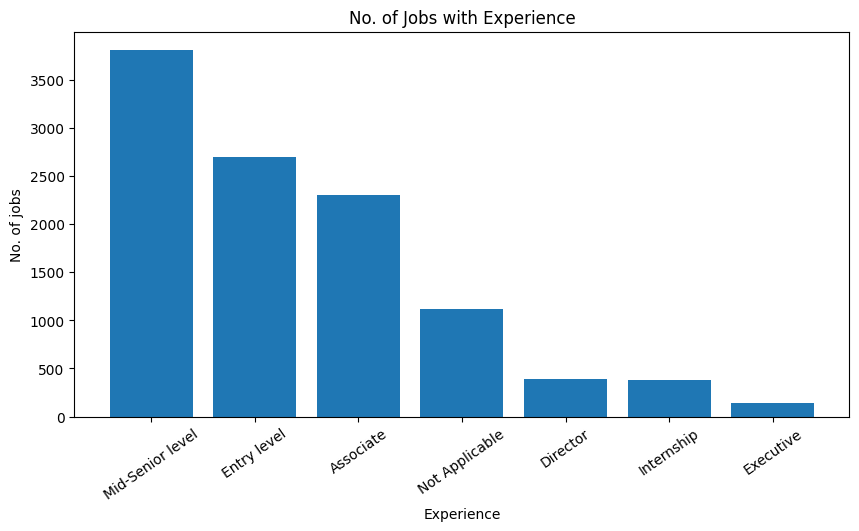

In [ ]:
# Trực quan hóa số lượng công việc yêu cầu kinh nghiệm khác nhau
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

In [ ]:
#10 công việc xuất hiện nhiều nhất trong tập dữ liệu
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [ ]:
# 10 tên công việc mà trong đó có số lượng tin tuyển dụng bị đánh dấu là lừa đảo nhiều nhất
print(data[data.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [ ]:
print(data[data.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [ ]:
# Kết hợp dữ liệu trong một cột để bắt đầu làm sạch dữ liệu 
# (title, location, company_profile, description, requirements, benefits) thành một cột duy nhất có tên là 'text'
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

In [ ]:
data

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,"Payroll Accountant US, PA, Philadelphia WebLin..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Studio..."


In [ ]:
# Tách ra hai tập dữ liệu khác nhau
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

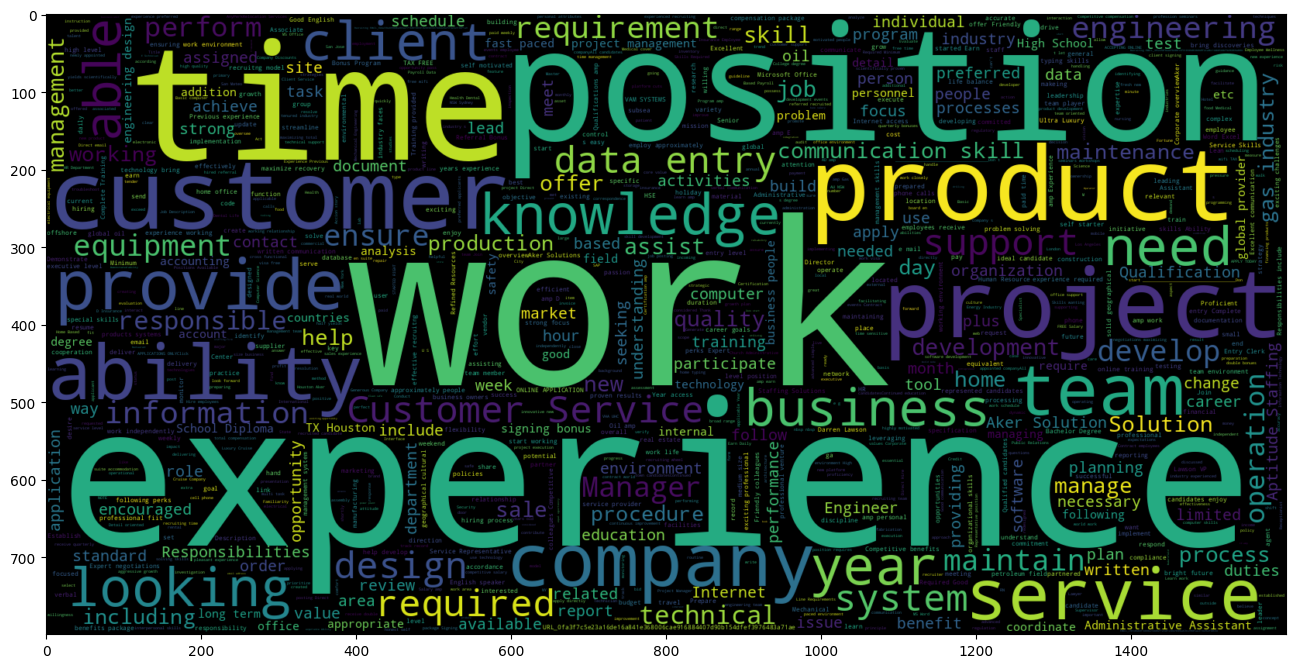

In [ ]:
# Tạo một wordcloud, biểu đồ trực quan hóa dữ liệu bằng cách sử dụng các từ có tần suất xuất hiện nhiều nhất trong văn bản
# Giúp ta hiểu rõ hơn về đặc điểm của dữ liệu các từ phổ biến trong tập dữ liệu các tin tuyển dụng lừa đảo
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

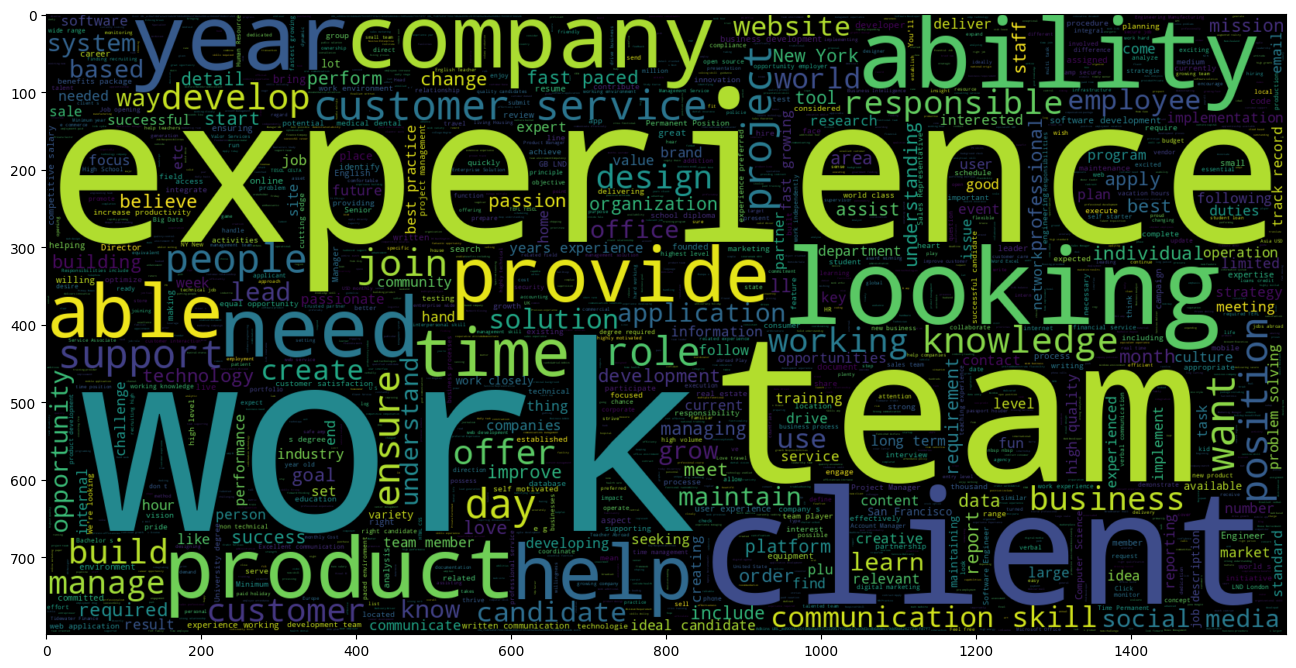

In [ ]:
# Từ phổ biến trong tập dữ liệu các tin tuyển dụng thật
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
!python -m spacy download en


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 230.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.9/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.9/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
!pip install spacy==2.3.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Tiền xử lý và làm sạch dữ liệu
# Tạo danh sách các dấu câu
punctuations = string.punctuation

# Tạo danh sách các từ dừng (stop words)
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Tải các thành phần xử lý ngôn ngữ tự nhiên bao gồm tokenizer, tagger, parser, NER và vectors từ tiếng Anh, dựa vào spacy
parser = English()

# Tạo hàm tokenizer của chúng tôi
def spacy_tokenizer(sentence):
    # Tạo đối tượng mã thông báo, được sử dụng để tạo tài liệu với các chú thích ngôn ngữ học.
    mytokens = parser(sentence)

    # Lấy từng mã thông báo (token), đưa về dạng gốc và chuyển sang chữ thường
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Loại bỏ các từ dừng ( stop words)
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Trả về danh sách các mã thông báo được tiền xử lý
    return mytokens

In [ ]:
# Tạo transformer tùy chỉnh bằng cách sử dụng spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Xử lý văn bản
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Hàm cơ bản để làm sạch văn bản
def clean_text(text):
    # Xóa khoảng trắng và chuyển đổi văn bản thành chữ thường
    return text.strip().lower()

In [ ]:
# Tách tập dữ liệu thành huấn luyện và kiểm tra
# data.text chứa các mẫu văn bản và data, fraudulent chứa nhãn tương ứng với mỗi mẫu
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

In [ ]:
#Kiểm tra kích thước của tập huấn luyện và tập kiểm
# X_train: tập dữ liệu huấn luyện (các câu văn bản)
# y_train: nhãn tương ứng với tập dữ liệu huấn luyện (giá trị "fraudulent" của các mẫu trong X_train)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516,)
(12516,)
(5364,)
(5364,)


In [ ]:
# Support Vector Machine Classifier
# Tạo chuỗi sự kiên với Bag of Words
# kỹ thuật biểu diễn văn bản bằng các vector số vector thể hiện số lần xuất hiện của từ tương ứng
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))),
                 ('classifier', SVC())])

# Huấn luyện mô hình
pipe.fit(X_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f6ccebcc3d0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f6cd30f2a60>)),
                ('classifier', SVC())])

In [ ]:
# Dự đoán với tập dữ liệu thử nghiệm
y_pred = pipe.predict(X_test)

# Độ chính xác của mô hình
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report\n")
# Chỉ số để đánh giá hiệu suất mô hình phân loại 
print(classification_report(y_test, y_pred))
print("Confusion Matrix\n")
# Confusion matrix là một bảng chứa thông tin về các dự đoán của mô hình phân loại trên tập dữ liệu kiểm tra
print(confusion_matrix(y_test, y_pred))

Classification Accuracy: 0.9794929157345265
Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5127
           1       1.00      0.54      0.70       237

    accuracy                           0.98      5364
   macro avg       0.99      0.77      0.84      5364
weighted avg       0.98      0.98      0.98      5364

Confusion Matrix

[[5127    0]
 [ 110  127]]


In [ ]:
# Chọn một mẫu dữ liệu ngẫu nhiên
sample_data = data.sample(1)

# Lấy nội dung text của mẫu dữ liệu
job_text = sample_data['text'].iloc[0]

# Phân loại mẫu dữ liệu bằng mô hình SVM đã huấn luyện
predicted_class = pipe.predict([job_text])[0]

# In kết quả phân loại
print('Mô hình dự đoán mẫu dữ liệu này là', predicted_class)

Mô hình dự đoán mẫu dữ liệu này là 0


In [ ]:
data

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,"Payroll Accountant US, PA, Philadelphia WebLin..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Studio..."


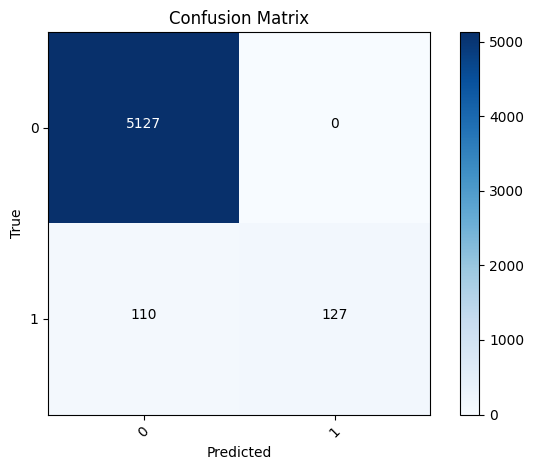

In [ ]:
import itertools

# Tính toán confusion matrix
# đánh giá chất lượng của mô hình phân loại bằng cách so sánh các dự đoán của mô hình với các giá trị thực tế
# cho biết số lượng các trường hợp dự đoán đúng và dự đoán sai trong mỗi nhóm
confusion_mat = confusion_matrix(y_test, y_pred)

# Vẽ confusion matrix
plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
tick_marks = np.arange(len(set(y_test))) # số lượng nhãn
class_labels = ['0', '1'] # nhãn
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = confusion_mat.max() / 2.
# Label các ô trên confusion matrix
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, format(confusion_mat[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


In [ ]:
# True Positive (TP): Số lượng trường hợp mà mô hình dự đoán đúng là positive (1) khi thực tế cũng là positive.

# False Positive (FP): Số lượng trường hợp mà mô hình dự đoán positive (1) nhưng thực tế lại là negative (0).

# False Negative (FN): Số lượng trường hợp mà mô hình dự đoán negative (0) nhưng thực tế lại là positive (1).

# True Negative (TN): Số lượng trường hợp mà mô hình dự đoán đúng là negative (0) khi thực tế cũng là negative.

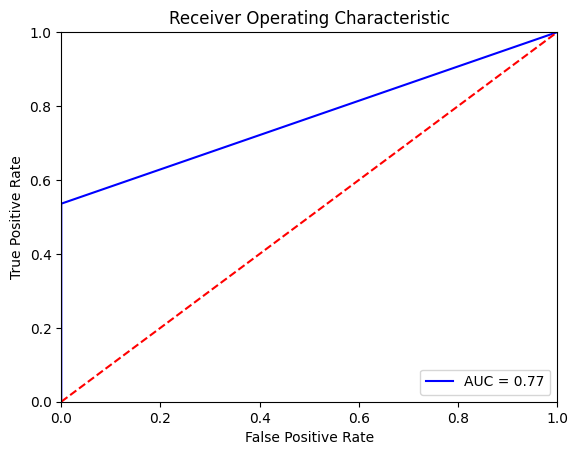

In [ ]:
# Đánh giá khả năng phân loại của một mô hình
# Một mô hình tốt hơn ngẫu nhiên sẽ có diện tích dưới đường ROC lớn hơn 0.5, và diện tích càng gần 1 thì mô hình càng tốt
# dự đoán trên tập test
from sklearn.metrics import roc_curve, auc

# Tính false positive rate (fpr), true positive rate (tpr) và ngưỡng (thresholds) của mô hình
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# K-Nearest Neighbors
# Tạo chuỗi sự kiện Bag of Words
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))),
                 ('classifier', KNeighborsClassifier())])

# Huấn luyện mô hình.
pipe.fit(X_train,y_train)



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f6cc9461250>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x7f6cd30f2a60>)),
                ('classifier', KNeighborsClassifier())])

In [ ]:
# Dự đoán với tập dữ liệu thử nghiệm
y_pred = pipe.predict(X_test)

# Độ chính xác của mô hình
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

Classification Accuracy: 0.7432885906040269
Classification Report

              precision    recall  f1-score   support

           0       1.00      0.73      0.85      5127
           1       0.14      0.96      0.25       237

    accuracy                           0.74      5364
   macro avg       0.57      0.85      0.55      5364
weighted avg       0.96      0.74      0.82      5364

Confusion Matrix

[[3759 1368]
 [   9  228]]


In [ ]:
# Chọn một mẫu dữ liệu ngẫu nhiên
sample_data = data.sample(2)

# Lấy nội dung text của mẫu dữ liệu
job_text = sample_data['text'].iloc[0]

# Phân loại mẫu dữ liệu bằng mô hình KNN đã huấn luyện
predicted_class = pipe.predict([job_text])[0]

# In kết quả phân loại
print('Mô hình dự đoán mẫu dữ liệu này là', predicted_class)

Mô hình dự đoán mẫu dữ liệu này là 1


In [ ]:
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


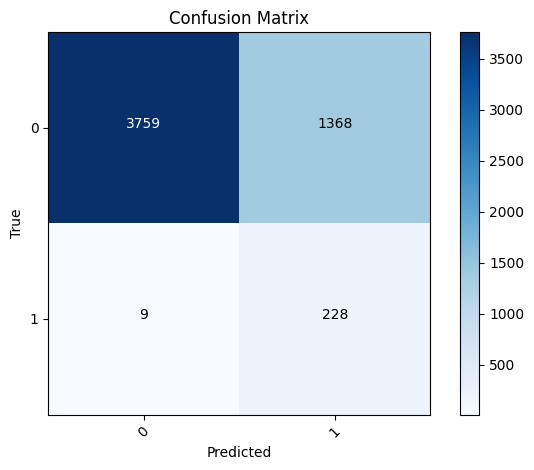

In [ ]:
import itertools

# Tính toán confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Vẽ confusion matrix
plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
tick_marks = np.arange(len(set(y_test))) # số lượng nhãn
class_labels = ['0', '1'] # nhãn
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = confusion_mat.max() / 2.
# Label các ô trên confusion matrix
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, format(confusion_mat[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# pipe_knn = Pipeline([
#     ('cleaner', predictors()),
#     ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))),
#     ('classifier', KNeighborsClassifier())
# ])
# parameters = {
#     'vectorizer__max_df': (0.5, 0.75, 1.0),
#     'vectorizer__max_features': (None, 5000, 10000),
#     'vectorizer__min_df': (1, 2),
#     'vectorizer__stop_words': (None, 'english'),
#     'classifier__n_neighbors': [3, 5, 7, 9, 11],
#     'classifier__weights': ['uniform', 'distance']
# }


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data.text[:500], data.fraudulent[:500], test_size=0.3, random_state=42)
# grid_knn = GridSearchCV(pipe_knn, parameters, cv=5, n_jobs=-1)
# grid_knn.fit(X_train, y_train)

In [ ]:
# y_pred_knn = grid_knn.predict(X_test)
# print("Classification Report:")
# print(classification_report(y_test, y_pred_knn))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_knn))
# print("Accuracy:", accuracy_score(y_test, y_pred_knn))
